In [2]:
from pathlib import Path
import dxcist
from dxcist.xcist_sims import run_simulation, get_projection_data, get_reconstructed_data
import matplotlib.pyplot as plt
from shutil import rmtree

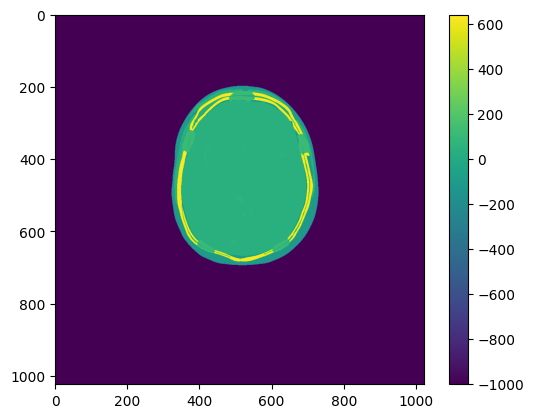

In [3]:
datadir = Path('/gpfs_projects/brandon.nelson/REALYSM_peds/torsos')
datadir = Path('/gpfs_projects/brandon.nelson/REALYSM_peds/heads')


phantom_ids = list(datadir.glob('*_atn_1.bin'))
phantom_ids

kVp_options = [80, 90, 100, 110, 120, 130, 140]
mA_options = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
slice_id = 310
slice_id = 110
# slice_id = 350 #peds
mA = 100
# mA = 50 # peds
kV = 120
FOV = 350
# FOV = 200

output_dir = 'output_images'
phantom_filename = phantom_ids[0]
phantom_filename = Path('/home/brandon.nelson/Dev/REALYSM_PedCT/head_lesion_infant/male_infant_ref_atn_1.bin')
# phantom_filename = datadir / 'male_infant_ref_atn_1.bin' # peds
phantom = dxcist.xcist_sims.load_volume(phantom_filename, shape=(251, 1024, 1024)) #whole phantom loaded as attenuation coefficients mu [1/pixels]
atten_coeffs = dxcist.xcist_sims.get_attenuation_coefficients(phantom_filename.parent/f'{phantom_filename.stem[:-5]}log')
mu_water = atten_coeffs['Body (water)']
ground_truth_image = dxcist.xcist_sims.mu_to_HU(phantom[slice_id], mu_water)
organ_mask = dxcist.xcist_sims.load_volume(phantom_filename.parent / phantom_filename.name.replace('atn', 'act'), shape=(251, 1024, 1024))[slice_id]
# add gray matter, white matter, csf
# HU values from https://en.wikipedia.org/wiki/Hounsfield_scale
# this is just for demo purposes, in practice I'll want to do this from XCAT and XCIST rather than manually assigning HUs
gm_mask = (organ_mask > 1041) & (organ_mask < 1049) # gray matter
bs_mask = (organ_mask > 1075) & (organ_mask < 1103) #brain stem
gm_mask = gm_mask | bs_mask
ground_truth_image[gm_mask] = 45 # assign gray matter value (extreme case for illustration)

wm_mask = (organ_mask > 1049) & (organ_mask < 1075) # white matter
ground_truth_image[wm_mask] = 20
# ground_truth_image[wm_mask] = 37 # peds

csf_mask = (organ_mask > 1035) & (organ_mask < 1039)
ground_truth_image[csf_mask] = 15

plt.imshow(ground_truth_image)
plt.colorbar()

In [4]:
dxcist.xcist_sims.convert_to_dicom(ground_truth_image, 'gt.dcm')

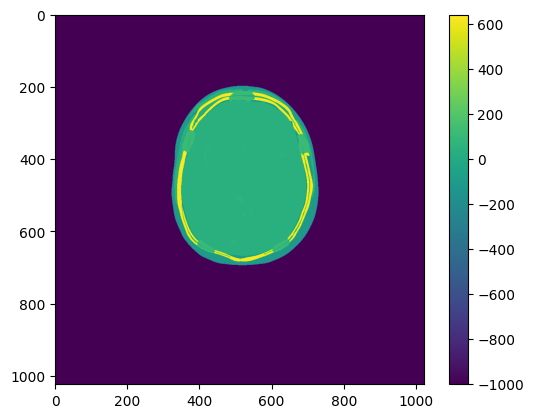

In [5]:
plt.imshow(ground_truth_image)
plt.colorbar()

*
*********************************************
* DICOM dataset information:
* Patient age: 000Y, sex: O
* Scanner: GE MEDICAL SYSTEMS RHAPSODE
* Study date & desciption: 20040119, e+1
* Technique: 120 kVp, 170 mA
* Reconstruction: STANDARD kernel, 338.671600-mm FOV
* Image: 0.661468-mm pixels (XY), 5.000000-mm slices (Z)
*********************************************
*
*********************************************
* Segmentation parameters:
* Using thresholds specified in the config file.
* Materials: ['ICRU_lung_adult_healthy', 'ICRU_adipose_adult2', 'water', 'ICRU_liver_adult', 'ICRU_skeleton_cortical_bone_adult']
* mu values (/cm): [0.05, 0.19, 0.21, 0.22, 0.6]
* mu(water) (/cm): 0.21
* Thresholds (/cm): [0.0, 0.16, 0.21, 0.23, 0.27]
* Thresholds (HU): [-1000.0, -200.0, 0.0, 100.0, 300.0]
*********************************************
* Calculating volume fraction maps for 5 materials and 1 slices...
* Writing volume fraction files for 5 materials and 1 slices, plus the HU data...
* 

100%|██████████| 1000/1000 [16:12<00:00,  1.03it/s]


Scan sim time: 972.7 s
Prep view
In LSC...

LSC Done...

Simulation is done.
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
* Writing the recon results to one big file...


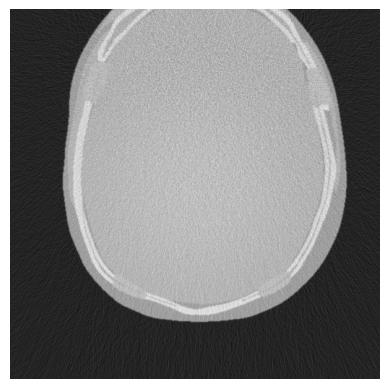

In [6]:
ct = run_simulation(ground_truth_image=ground_truth_image, output_dir=output_dir, phantom_id=phantom_filename.stem[:-6],
                    slice_id=slice_id, mA=mA, kVp=kV,
                    mu_water=mu_water, FOV=FOV)

In [7]:
recon = get_reconstructed_data(ct)
dxcist.xcist_sims.convert_to_dicom(recon[:,:,0], 'recon.dcm')

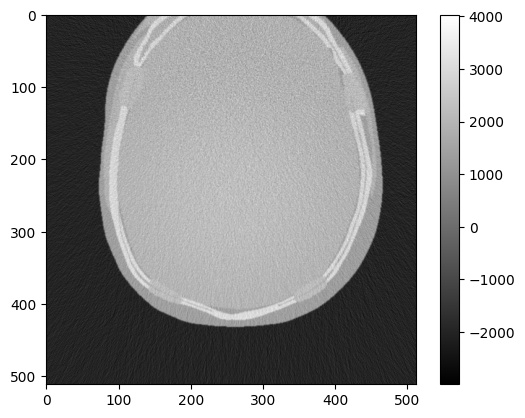

In [12]:
plt.imshow(recon -1024, cmap='gray')
plt.colorbar()

Pixels in organ mask: 1232697.0


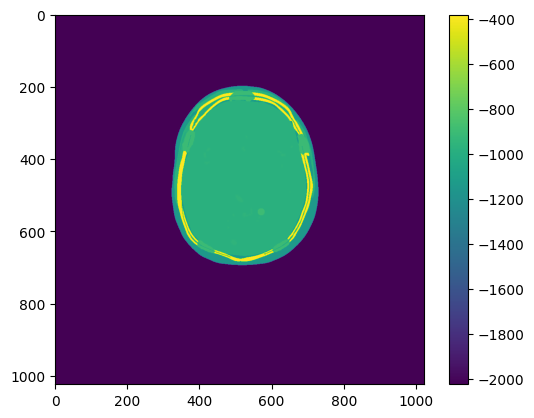

In [18]:
from dxcist.lesions import add_random_circle_lesion

radius = 10
# radius = 10 #peds
contrast = 80

brain_mask = organ_mask > 3
              
print(f'Pixels in organ mask: {organ_mask.sum()}')
if organ_mask.sum() > 1:
    img_w_lesion, lesion_image, lesion_coords = add_random_circle_lesion(ground_truth_image, brain_mask, radius=radius, contrast=contrast)
    img_w_lesion -= 1024
plt.imshow(img_w_lesion)
plt.colorbar()

In [19]:
dxcist.xcist_sims.convert_to_dicom(img_w_lesion, 'gt_lesion.dcm')
img_w_lesion -= 1024

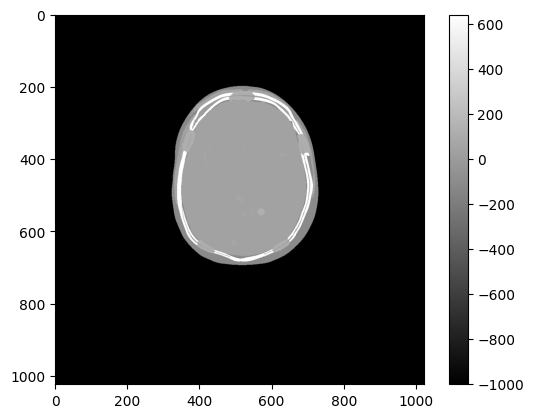

In [21]:
img_w_lesion += 1024
plt.imshow(img_w_lesion, cmap='gray')
plt.colorbar()

*
*********************************************
* DICOM dataset information:
* Patient age: 000Y, sex: O
* Scanner: GE MEDICAL SYSTEMS RHAPSODE
* Study date & desciption: 20040119, e+1
* Technique: 120 kVp, 170 mA
* Reconstruction: STANDARD kernel, 338.671600-mm FOV
* Image: 0.661468-mm pixels (XY), 5.000000-mm slices (Z)
*********************************************
*
*********************************************
* Segmentation parameters:
* Using thresholds specified in the config file.
* Materials: ['ICRU_lung_adult_healthy', 'ICRU_adipose_adult2', 'water', 'ICRU_liver_adult', 'ICRU_skeleton_cortical_bone_adult']
* mu values (/cm): [0.05, 0.19, 0.21, 0.22, 0.6]
* mu(water) (/cm): 0.21
* Thresholds (/cm): [0.0, 0.16, 0.21, 0.23, 0.27]
* Thresholds (HU): [-1000.0, -200.0, 0.0, 100.0, 300.0]
*********************************************
* Calculating volume fraction maps for 5 materials and 1 slices...
* Writing volume fraction files for 5 materials and 1 slices, plus the HU data...
* 

100%|██████████| 1000/1000 [16:09<00:00,  1.03it/s]


Scan sim time: 969.7 s
Prep view
In LSC...

LSC Done...

Simulation is done.
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
* Writing the recon results to one big file...


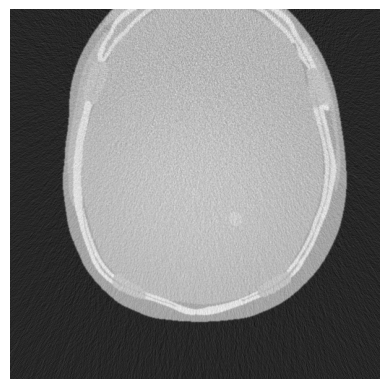

In [22]:
ct = run_simulation(ground_truth_image=img_w_lesion, output_dir=output_dir, phantom_id=phantom_filename.stem[:-6],
                    slice_id=slice_id, mA=mA, kVp=kV,
                    mu_water=mu_water, FOV=FOV)

In [23]:
recon = get_reconstructed_data(ct)
dxcist.xcist_sims.convert_to_dicom(recon[:, :, 0], 'recon_lesion.dcm')

 now repeat for a pediatric case
 phantom_filename = datadir / 'male_infant_ref_atn_1.bin'

In [ ]:
#  test phantom case
cct189 = dxcist.xcist_sims.load_volume('true_disk.raw', shape=(512, 512), dtype='uint16').astype('float') - 1024

ct = run_simulation(ground_truth_image=cct189,
                    output_dir=output_dir,
                    phantom_id=f'CCT189_{mA}mA_{kV}kV',
                    slice_id=slice_id, mA=mA, kVp=kV,
                    FOV=350)
recon = get_reconstructed_data(ct)
# %%
plt.imshow(recon, cmap='gray')
plt.colorbar()
# %%